In [1]:
import torch 
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
# import util
from datetime import date
import argparse
from progressbar import *
import datetime

In [2]:
# ! pip install progressbar

## Config

In [3]:
# config 

num_epochs = 100
step_per_epoch = 3
n_layers = 1
likelihood = 'g'
num_obs_to_train = 168
embedding_size = 10
hidden_size = 50
seq_len = 60
batch_size=64

## Load data

In [10]:
data_path = '../dataset'

data = pd.read_csv(os.path.join(data_path, "LD_MT200_hour.csv"), parse_dates=["date"])
data["year"] = data["date"].apply(lambda x: x.year)
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
data = data.loc[(data["date"] >= pd.to_datetime('2014, 1, 1')) & (data["date"] <= pd.to_datetime('2014, 3, 1'))]

features = ["hour", "day_of_week"]
# hours = pd.get_dummies(data["hour"])
# dows = pd.get_dummies(data["day_of_week"])
hours = data["hour"]
dows = data["day_of_week"]

In [6]:
def train_test_split(X, y, train_ratio=0.7):
    num_ts, num_periods, num_features = X.shape
    train_periods = int(num_periods * train_ratio)
    random.seed(2)
    Xtr = X[:, :train_periods, :]
    ytr = y[:, :train_periods]
    Xte = X[:, train_periods:, :]
    yte = y[:, train_periods:]
    return Xtr, ytr, Xte, yte

In [7]:
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int):
    seq_len (int): sequence/encoder/decoder length
    batch_size (int)
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

In [8]:
from torch.utils.data import Dataset
import torch
from torch.utils import data
from torch.utils.data import DataLoader
class WindowDataset(Dataset):
    '''
    Build a custom dataset 
    
    --Return--
    
    x: inputs
    y: targets 
    z: features
    ----------
    
    '''
    
    def __init__(self, data, input_window, output_window, stride=1):
        # total data length 
        L = data.shape[0]
        
        # total number of samples with stride
        num_samples = (L - input_window - output_window) // stride + 1
        
        # input, output 
        X = []
        Y = []
        Xf = []
        Yf = []
        
        for i in range(num_samples):
            start_x = stride*i
            end_x = start_x + input_window 
            Y.append(data.iloc[start_x: end_x, 0].values)
            X.append(data.iloc[start_x: end_x, 1:].values)
            start_y = stride*i + input_window
            end_y = start_y + output_window 
            Yf.append(data.iloc[start_y:end_y, 0].values)
            Xf.append(data.iloc[start_y:end_y, 1:].values)
            
        self.X = X
        self.Y = Y
        self.Xf = Xf
        self.Yf = Yf
        
        self.len = len(X)
            
    def __len__(self):
        return self.len 
    
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.X[idx])
        Y = torch.FloatTensor(self.Y[idx])
        Y = Y.unsqueeze(-1)
        Xf = torch.FloatTensor(self.Xf[idx])
        Yf = torch.FloatTensor(self.Yf[idx])
        Yf = Yf.unsqueeze(-1)
        
        return X, Y, Xf, Yf

In [41]:
data.shape

(1440, 3)

In [42]:
train_periods = int(data.shape[0] * 0.8)
train_periods

1152

In [43]:
data_tr = data.iloc[:train_periods, :]
data_te = data.iloc[train_periods:, :]

In [44]:
data_tr.shape

(1152, 3)

In [45]:
data_te.shape

(288, 3)

In [46]:
data_tr = data_tr[['MT_200','hour','day_of_week']]
data_tr.reset_index(drop=True, inplace=True)

In [47]:
custom_dataset = WindowDataset(data_tr, 168, 60)
dataloader = DataLoader(custom_dataset, batch_size)  
X, Y, Xf, Yf = next(iter(dataloader))

In [48]:
X.shape

torch.Size([64, 168, 2])

In [49]:
Y.shape

torch.Size([64, 168, 1])

In [50]:
Xf.shape

torch.Size([64, 60, 2])

In [51]:
Yf.shape

torch.Size([64, 60, 1])

In [180]:
class Gaussian(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)
    
    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(h).squeeze(0)
        return mu_t, sigma_t

def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation
    gaussian maximum likelihood using log 
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample()
    if ypred.dim() == 1:
        ypred = ypred.unsqueeze(0)
    return ypred

def gaussian_likelihood_loss(z, mu, sigma):
    '''
    Gaussian Liklihood Loss
    Args:
    z (tensor): true observations, shape (num_ts, num_periods)
    mu (tensor): mean, shape (num_ts, num_periods)
    sigma (tensor): standard deviation, shape (num_ts, num_periods)
    likelihood: 
    (2 pi sigma^2)^(-1/2) exp(-(z - mu)^2 / (2 sigma^2))
    log likelihood:
    -1/2 * (log (2 pi) + 2 * log (sigma)) - (z - mu)^2 / (2 sigma^2)
    '''
    negative_likelihood = torch.log(sigma + 1) + (z - mu) ** 2 / (2 * sigma ** 2) + 6
    return negative_likelihood.mean()

In [181]:
class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        if likelihood == "g":
            self.likelihood_layer = Gaussian(hidden_size, 1)

        self.likelihood = likelihood

    def forward(self, X, y, Xf):
        num_ts, seq_len, _ = X.size() # 64, 168, 2
        _, output_horizon, num_features = Xf.size() # 64, 60, 2

        ynext = None
        ypred = []
        mus = []
        sigmas = []       
        h, c = None, None
        for s in range(seq_len + output_horizon):
            if s < seq_len:
                ynext = y[:, s].view(-1, 1) # (batch_size, 1) 
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = X[:, s, :].view(num_ts, -1) # (batch_size, num_feature)
            else:
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = Xf[:, s-seq_len, :].view(num_ts, -1) # (batch_size, num_feature)
            x = torch.cat([x, yembed], dim=1) # (batch_size, num_feature+embed_size)
            inp = x.unsqueeze(1) # (batch_size, 1, num_feature+embed_size)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))

            hs = h[-1, :, :] # (batch_size, hidden_size)
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            if self.likelihood == 'g':
                ynext = gaussian_sample(mu, sigma)

            if s >= seq_len - 1 and s < output_horizon + seq_len - 1:
                ypred.append(ynext)
                
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma   
        

In [182]:
model = DeepAR(2, embedding_size, hidden_size, n_layers)

In [146]:
ypred, mu, sigma = model(X, Y, Xf)

In [147]:
ypred.shape

torch.Size([64, 60])

In [148]:
mu.shape

torch.Size([64, 228])

In [149]:
sigma.shape

torch.Size([64, 228])

In [150]:
def gaussian_likelihood_loss(z, mu, sigma):
    '''
    Gaussian Liklihood Loss
    Args:
    z (tensor): true observations, shape (num_ts, num_periods)
    mu (tensor): mean, shape (num_ts, num_periods)
    sigma (tensor): standard deviation, shape (num_ts, num_periods)
    likelihood: 
    (2 pi sigma^2)^(-1/2) exp(-(z - mu)^2 / (2 sigma^2))
    log likelihood:
    -1/2 * (log (2 pi) + 2 * log (sigma)) - (z - mu)^2 / (2 sigma^2)
    '''
    negative_likelihood = torch.log(sigma + 1) + (z - mu) ** 2 / (2 * sigma ** 2) + 6
    return negative_likelihood.mean()

In [151]:
ytrain_tensor = torch.cat([Y, Yf], dim=1)
ytrain_tensor.shape

torch.Size([64, 228, 1])

In [152]:
z = ytrain_tensor.squeeze(2)

negative_likelihood = torch.log(sigma + 1) + (z - mu) ** 2 / (2 * sigma ** 2) + 6
negative_likelihood.shape

torch.Size([64, 228])

In [153]:
loss = negative_likelihood.mean()

In [154]:
loss.item()

9028553.0

## test

In [183]:
data_te = data_te[['MT_200','hour','day_of_week']]
data_te.reset_index(drop=True, inplace=True)

custom_dataset = WindowDataset(data_te, 168, 60)
dataloader = DataLoader(custom_dataset, batch_size)  
X_te, Y_te, Xf_te, Yf_te = next(iter(dataloader))

In [184]:
batch_size = 1

In [185]:
X_te.shape

torch.Size([1, 168, 2])

In [186]:
Y_te.shape

torch.Size([1, 168, 1])

In [225]:
# scaler

class MeanScaler:
    
    def fit_transform(self, y):
        self.mean = np.mean(y)
        return y / self.mean
    
    def inverse_transform(self, y):
        return y * self.mean

    def transform(self, y):
        return y / self.mean

yscaler = MeanScaler()
tmp = yscaler.fit_transform(data_tr['MT_200'])

In [227]:
yte = Y_te[-1, -seq_len-num_obs_to_train:].data.numpy()
yte_ = yscaler.inverse_transform(yte)

In [228]:
yte_.shape

(168, 1)

In [230]:
Yf_te.shape

torch.Size([1, 60, 1])

In [231]:
Y_te.shape

torch.Size([1, 168, 1])

In [234]:
torch.concat([Y_te, Yf_te], dim=1).shape

torch.Size([1, 228, 1])

In [235]:
-seq_len-num_obs_to_train

-228

In [187]:
Xf_te.shape

torch.Size([1, 60, 2])

In [188]:
Yf_te.shape

torch.Size([1, 60, 1])

In [189]:
sample_size = 100

In [192]:
y_pred, _, _ = model(X_te, Y_te, Xf_te)
# y_pred.shape

In [193]:
y_pred.shape

torch.Size([1, 60])

In [194]:
result = []
for _ in tqdm(range(sample_size)):
    y_pred, _, _ = model(X_te, Y_te, Xf_te)
    y_pred = y_pred.data.numpy()

    result.append(y_pred.reshape((-1, 1)))

100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


In [196]:
len(result)

100

In [197]:
result[0].shape

(60, 1)

In [198]:
result = np.concatenate(result, axis=1)
p50 = np.quantile(result, 0.5, axis=1)
p90 = np.quantile(result, 0.9, axis=1)
p10 = np.quantile(result, 0.1, axis=1)

In [200]:
p50.shape

(60,)

In [201]:
p50

array([-0.03009538, -0.02218692,  0.03299258,  0.01920479, -0.05741754,
        0.07099628,  0.04896922, -0.06096033, -0.07469083, -0.16407361,
        0.07148814,  0.00889914,  0.06148287,  0.04910575,  0.06924444,
        0.08458638,  0.04952827, -0.06622264,  0.09452424,  0.26115923,
        0.19488801,  0.05889913,  0.14810732,  0.02208678,  0.13827085,
        0.10198727,  0.14348288,  0.24632914,  0.16116728,  0.06796674,
        0.0489604 ,  0.14374632, -0.02142227,  0.06214692,  0.05470119,
        0.06534778,  0.08969665,  0.22585706,  0.17956793,  0.19355664,
        0.08889241,  0.08711808,  0.1115716 ,  0.11639291,  0.05273512,
        0.22495956,  0.10837707,  0.17617386,  0.08326267,  0.03783518,
        0.23851304,  0.09581303,  0.14109491,  0.18959032,  0.05056559,
       -0.02457627,  0.17816032, -0.02600614,  0.22529436,  0.04574969])

In [202]:
plt.figure(1, figsize=(20, 5))
plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [206]:
seq_len = 60

In [211]:
Y_te[-1, -seq_len-num_obs_to_train:].shape

torch.Size([168, 1])

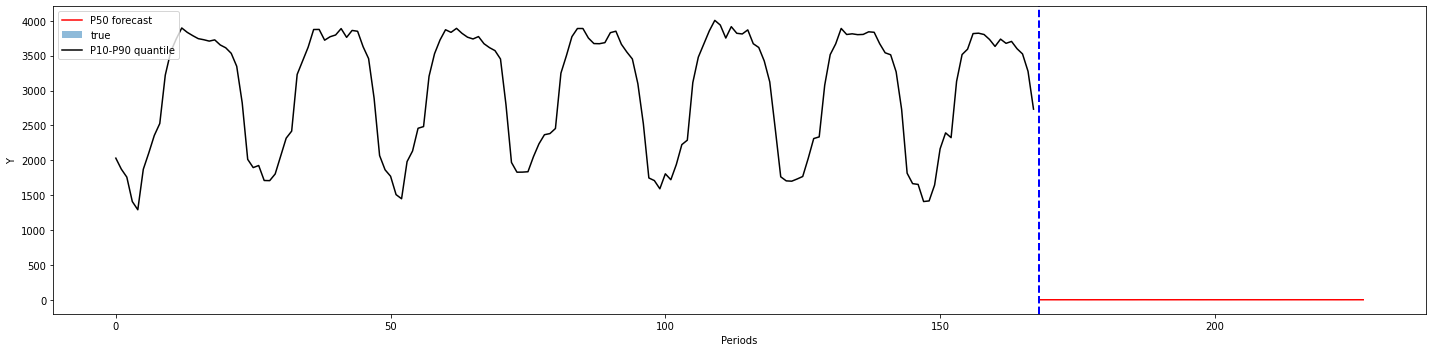

In [220]:
plt.figure(1, figsize=(20, 5))
plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
yplot = Y_te[-1, -seq_len-num_obs_to_train:]
plt.plot(range(len(yplot)), yplot, "k-")
plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
ymin, ymax = plt.ylim()
plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
plt.ylim(ymin, ymax)
plt.xlabel("Periods")
plt.ylabel("Y")


plt.tight_layout()
# plt.show()
plt.savefig('./tmp.png')

In [ ]:
X_te, Y_te, Xf_te, Yf_te = next(iter(test_dataloader))  
